In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [13]:
# Transformasi gambar (resize, normalisasi, augmentasi)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Tambahkan blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = torchvision.datasets.ImageFolder(root="D:\\TA_Lalu_Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root="D:\\TA_Lalu_Lintas\\TA-Lalu-Lintas\\dataset_cnn_preprocessed\\test", transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Label kelas
class_names = train_dataset.classes
num_classes = len(class_names)
print("Kelas Dataset:", class_names)


Kelas Dataset: ['Memakai-Helm', 'Tidak-Memakai-Helm']


In [ ]:
def get_pretrained_model(model_name, num_classes):
    if model_name == "shufflenet":
        weights = models.ShuffleNet_V2_X1_0_Weights.DEFAULT
        model = models.shufflenet_v2_x1_0(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet":
        weights = models.EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "mobilenet":
        weights = models.MobileNet_V2_Weights.DEFAULT
        model = models.mobilenet_v2(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "squeezenet":
        weights = models.SqueezeNet1_0_Weights.DEFAULT
        model = models.squeezenet1_0(weights=weights)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1))
    else:
        raise ValueError("Model tidak ditemukan!")

    return model

# Pilih model (ganti dengan model yang ingin digunakan)
model_name = "squeezenet"  # Bisa diganti dengan "shufflenet", "efficientnet", "resnet18", atau "squeezenet"
model = get_pretrained_model(model_name, num_classes)

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

d:\ComputerVision\belajarConda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ComputerVision\belajarConda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\User/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:02<00:00, 2.23MB/s]


In [ ]:
EPOCHS = 25
patience = 5  # Jumlah epoch yang diperbolehkan tanpa peningkatan
best_val_loss = float("inf")
early_stopping_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# === 4. Training & Validation Loop ===
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct_train / total_train)

    # === 5. Validasi ===
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)

            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100. * correct_val / total_val)

    # === 6. Hitung Metrik Evaluasi ===
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}% | "
          f"Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}")

    # === 7. Early Stopping ===
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), f"best_model_{model_name}.pth")  # Simpan model terbaik
        early_stopping_counter = 0  # Reset counter jika ada perbaikan
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

Epoch 1/25 | Train Loss: 0.6826, Train Acc: 58.78% | Val Loss: 0.6594, Val Acc: 56.07% | Acc: 0.5607, Prec: 0.5749, Rec: 0.5607, F1: 0.5388
Epoch 2/25 | Train Loss: 0.5402, Train Acc: 71.42% | Val Loss: 0.5493, Val Acc: 69.64% | Acc: 0.6964, Prec: 0.7388, Rec: 0.6964, F1: 0.6823
Epoch 3/25 | Train Loss: 0.4475, Train Acc: 79.48% | Val Loss: 0.4354, Val Acc: 81.07% | Acc: 0.8107, Prec: 0.8126, Rec: 0.8107, F1: 0.8104
Epoch 4/25 | Train Loss: 0.3418, Train Acc: 85.22% | Val Loss: 0.4581, Val Acc: 75.36% | Acc: 0.7536, Prec: 0.7998, Rec: 0.7536, F1: 0.7437
Epoch 5/25 | Train Loss: 0.3177, Train Acc: 86.11% | Val Loss: 0.3106, Val Acc: 86.79% | Acc: 0.8679, Prec: 0.8683, Rec: 0.8679, F1: 0.8678
Epoch 6/25 | Train Loss: 0.2851, Train Acc: 87.54% | Val Loss: 0.2392, Val Acc: 90.36% | Acc: 0.9036, Prec: 0.9038, Rec: 0.9036, F1: 0.9036
Epoch 7/25 | Train Loss: 0.2799, Train Acc: 88.80% | Val Loss: 0.2895, Val Acc: 87.14% | Acc: 0.8714, Prec: 0.8763, Rec: 0.8714, F1: 0.8710
Epoch 8/25 | Train L

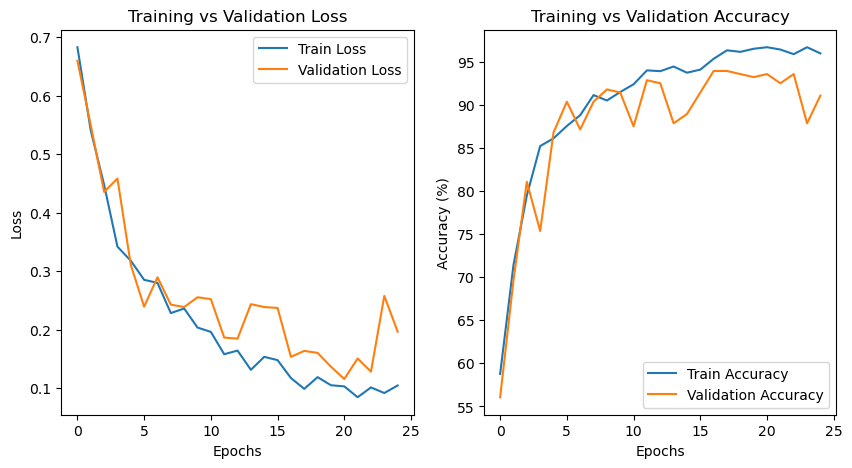

In [16]:
# === 8. Visualisasi Training vs Validation ===
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fungsi untuk load model pretrained
def get_pretrained_model(model_name, num_classes):
    if model_name == "shufflenet":
        model = models.shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "squeezenet":
        model = models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1))
    else:
        raise ValueError("Model tidak ditemukan!")
    return model

# Transformasi data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Parameter
model_name = "efficientnet"  # ganti sesuai kebutuhan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 25
BATCH_SIZE = 32
PATIENCE = 5

# Folder dasar k-fold
base_dir = "D:\\TA_Lalu_Lintas\\TA-Lalu-Lintas\\dataset_cnn_kfold"
num_folds = 4

for fold in range(num_folds):
    print(f"\n📦 Training Fold {fold}...\n")

    train_dir = os.path.join(base_dir, f"fold{fold}", "train")
    val_dir = os.path.join(base_dir, f"fold{fold}", "val")

    train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    num_classes = len(train_dataset.classes)
    model = get_pretrained_model(model_name, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    best_val_loss = float("inf")
    early_stopping_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100. * correct_train / total_train

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                total_val += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = 100. * correct_val / total_val
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average="macro")
        recall = recall_score(all_labels, all_preds, average="macro")
        f1 = f1_score(all_labels, all_preds, average="macro")

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
              f"Loss: {val_loss:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_fold{fold}_{model_name}.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= PATIENCE:
            print("⏹️ Early stopping triggered!")
            break


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject